In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
from cmdstanpy import CmdStanModel
import json
from tqdm.notebook import tqdm
import seaborn as sns
import os
from IPython.display import display, HTML

In [2]:
# use common std for each material
G_std = np.max([181.13824944934223,
                111.76599039086933,
                172.19710517720915,
                45.61096871752792])

phi_std = np.max([5.583209074729597,
                2.43281682456478,
                11.339687752784396,
                3.7478613175943716])

In [3]:
full_path = os.path.split(os.getcwd())[0]

In [4]:
def pred(model_name,diagnose=False):
    """Preprocess data and fit model
        model_name: name of the stan model e.g hier_material (no .stan)
        diagnoise: print mcmc diagnostics, rhat...
        returns: tuple of two dicts where keys are G_abs and phi_(deg)
                first containts the mcmc samples as pandas dataframe
                secods contains arviz datastructure for visualizations
    """
    out = {}
    az_out = {}
    data_all = pd.read_csv(os.path.join(full_path,'heterogeneity','data','hetero_data.csv'))
    # process mechanical properties separately
    for g_a in ['G_abs','phi_(deg)']:
        samples = []
        out[g_a] = {}
        # combine information of all materials
        for ss in ['GrowDex','Fibrin','GrowDex-Collagen','Agarose']: 
            data_type = ss
            data = data_all[data_all['type']==data_type]

            sample_num = []
            prev = None
            idx = 1
            for i in data['day']:
                if prev is None:
                    prev = i
                if prev != i:
                    idx += 1
                    prev = i
                sample_num.append(idx)
            data['sample_num'] = sample_num
            if ss=='Fibrin':
                u_i = data['sample'].unique()
                iid = np.arange(1,u_i.shape[0]+1)
                s_out = data['sample'].copy()
                for ii,i in enumerate(u_i):
                    s_out[data['sample']==i] = iid[ii]
                data['sample_num'] = s_out

            subset = data[['sample_num','holder','location','track_id',g_a]]
            subset['sample_num'] = subset['sample_num'].astype(int)
            sample_ids = []
            location_ids = []
            holder_ids = []
            track_ids = []
            n_loc = 0
            n_hold = 0
            n_samp = 0
            # we want consecutive numbering
            for i in subset['sample_num'].unique():
                sub_sample = subset[subset['sample_num']==i]
                sample_ids.extend([int(i)]*sub_sample['holder'].unique().shape[0])
                for jj,j in enumerate(sub_sample['holder'].unique()):
                    sub = sub_sample[sub_sample['holder']==j]
                    holder_ids.extend([int(jj+1)+n_samp]*sub['location'].unique().shape[0])
                    for kk,k in enumerate(sub['location'].unique()):
                        sub2 = sub[sub['location']==k]
                        location_ids.extend([int(kk+1)+n_hold]*sub2['track_id'].unique().shape[0])
                        for zz,z in enumerate(sub2['track_id'].unique()):
                            sub3 = sub2[sub2['track_id']==z]
                            track_ids.extend([int(zz+1)+n_loc]*sub3.shape[0])
                        n_loc += int(sub2['track_id'].unique().shape[0])
                    n_hold += int(sub['location'].unique().shape[0])
                n_samp += int(sub_sample['holder'].unique().shape[0])

            # normalize mean to zero and with common std
            y_raw = subset[g_a].values
            y = y_raw-np.mean(y_raw)
            if g_a == 'G_abs':
                y = y_raw/G_std
            else:
                y = y_raw/phi_std
            #y = (y_raw-np.mean(y_raw))/(np.std(y_raw))
            sample = {'N':subset.shape[0],
                      'N_samples':int(np.max(sample_ids)),
                      'N_holders': int(np.max(holder_ids)),
                      'N_locations': int(np.max(location_ids)),
                      'N_ids':int(np.max(track_ids)),
                      'sample_ids':sample_ids,
                      'holder_ids':holder_ids,
                      'location_ids':location_ids,
                      'track_ids':track_ids,
                      'train_ids':(np.arange(len(track_ids))+1).tolist(),
                      'N_train': subset.shape[0],
                      'y':y.tolist()}

            samples.append(sample.copy())

        # combine different materials into a single dict/json for stan
        combined = samples[0]
        combined['material_ids'] = np.ones(combined['N_samples'],dtype=int).tolist()
        s_max = combined['N_samples']
        h_max = combined['N_holders']
        l_max = combined['N_locations']
        t_max = combined['N_ids']
        m_max = 1
        for s in samples[1:]:
            #print(s['N'])
            combined['N'] += s['N']
            combined['N_samples'] += s['N_samples']
            combined['N_holders'] += s['N_holders']
            combined['N_locations'] += s['N_locations']
            combined['N_ids'] += s['N_ids']
            combined['sample_ids'].extend((np.array(s['sample_ids'])+s_max).tolist())
            combined['holder_ids'].extend((np.array(s['holder_ids'])+h_max).tolist())
            combined['location_ids'].extend((np.array(s['location_ids'])+l_max).tolist())
            combined['track_ids'].extend((np.array(s['track_ids'])+t_max).tolist())
            combined['y'].extend(s['y'])
            combined['material_ids'].extend((np.ones(s['N_samples'],dtype=int)+m_max).tolist())

            s_max += s['N_samples']
            h_max += s['N_holders']
            l_max += s['N_locations']
            t_max += s['N_ids']
            m_max += 1

        combined['train_ids'] = ((np.arange(combined['N'])+1).astype(int)).tolist()
        combined['N_train'] = len(combined['train_ids'])

        combined['sample_ids'] = combined['sample_ids']
        combined['holder_ids'] = combined['holder_ids']
        combined['location_ids'] = combined['location_ids']
        combined['track_ids'] = combined['track_ids']
        combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
        combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
        combined['N_materials'] = len(samples)
        json_path = os.path.join(full_path,'heterogeneity','data',f'hier_data_{g_a}.json')
        with open(json_path,'w') as f:
            json.dump(combined,f)
        
        model4 = CmdStanModel(stan_file=os.path.join(full_path,'heterogeneity','models',f'{model_name}.stan'))
        fit4 = model4.sample(data=json_path,
                           adapt_delta=0.9999999999999999,max_treedepth=20,iter_sampling=2000)
        if diagnose:
            print(fit4.diagnose())
        az_data4 = az.from_cmdstanpy(posterior=fit4,
                                   posterior_predictive='y_hat',
                                   log_likelihood='log_likelihood',
                                   observed_data={'y':combined['y']})
        out[g_a] = fit4.draws_pd()
        az_out[g_a] = az_data4
    return out,az_out

In [5]:
hh,az_out = pred('hier_material',True)

/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Processing csv files: /tmp/tmp7euucpm2/hier_material-202212231211-1-3n10srfd.csv, /tmp/tmp7euucpm2/hier_material-202212231211-2-ahzgnebs.csv, /tmp/tmp7euucpm2/hier_material-202212231211-3-ya6xs8k9.csv, /tmp/tmp7euucpm2/hier_material-202212231211-4-0__muy__.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:Processing csv files: /tmp/tmp7euucpm2/hier_material-202212231216-1-pdtv2mmw.csv, /tmp/tmp7euucpm2/hier_material-202212231216-2-l1hwlj_j.csv, /tmp/tmp7euucpm2/hier_material-202212231216-3-gtgv_wps.csv, /tmp/tmp7euucpm2/hier_material-202212231216-4-jg0708en.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters

Processing csv files: /tmp/tmp7euucpm2/hier_material-202212231216-1-pdtv2mmw.csv, /tmp/tmp7euucpm2/hier_material-202212231216-2-l1hwlj_j.csv, /tmp/tmp7euucpm2/hier_material-202212231216-3-gtgv_wps.csv, /tmp/tmp7euucpm2/hier_material-202212231216-4-jg0708en.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


### Some diagnostic plots

* Blue dots are raw datapoints and bars are model estimates

Notes:
* Extreme values do not change the estimates too much (as they shouldn't)
* As can be seen in most holders there are only a few particles
* Sometimes only a single repeat is measured
* Uncertainty seems to be increasing when we have only a single repeat

### Holders colored

In [19]:
def vis_raw(effect):
    fig,ax = plt.subplots(1,2,figsize=(10,18))
    for ii,visco in enumerate(hh.keys()):
        with open(f'data/hier_data_{visco}.json','r') as f:
            data = json.load(f)
        ys = pd.DataFrame({'variable':np.array(data['track_ids'])-1,
                           'value':data['y'],})
        ys['type'] = 'data'
        hats = hh[visco].filter(regex=r'y_hat2')
        hats.columns = list(map(lambda x: int(x.split('[')[-1][:-1])-1,hats.columns))
        hat_melt = pd.melt(hats)
        if effect == 'location':
            ll_id = np.array(data['location_ids'])[(np.array(data['track_ids'])-1)]
        elif effect == 'holder':
            ll_id = np.array(data['holder_ids'])[np.array(data['location_ids'])-1][(np.array(data['track_ids'])-1)]
        elif effect == 'material':
            ll_id = np.array(data['material_ids'])[np.array(data['sample_ids'])
                                                   [np.array(data['holder_ids'])[np.array(data['location_ids'])-1]
                                                    [(np.array(data['track_ids'])-1)]-1]-1]
        ll = []
        for idx,i in enumerate(np.unique(np.array(data['track_ids']))):
            ll.append(np.min(ll_id[np.array(data['track_ids'])==i]))

        hat_melt['loc_id'] = np.repeat(ll,hh[visco].shape[0])
        hat_melt['variable'] = hat_melt['variable'].astype(str) 
        sns.boxplot(data=hat_melt,y='variable',x='value',hue='loc_id',
                    palette=sns.color_palette("Set2"),ax=ax[ii],width=1,dodge=False,fliersize=0)
        sns.scatterplot(data=ys,y='variable',x='value',color='blue',ax=ax[ii])
        ax[ii].get_legend().remove()
        if visco == 'phi_(deg)':
            ax[ii].set_xlim([-4,4])
        else:
            ax[ii].set_xlim([-2.8,5])
        ax[ii].set_title(f'{visco}')
        ax[ii].set_xticks([])
        if ii==1:
            ax[ii].set_ylabel('magnetic probe')
        else:
            ax[ii].set_ylabel('magnetic probe')
    fig.tight_layout()

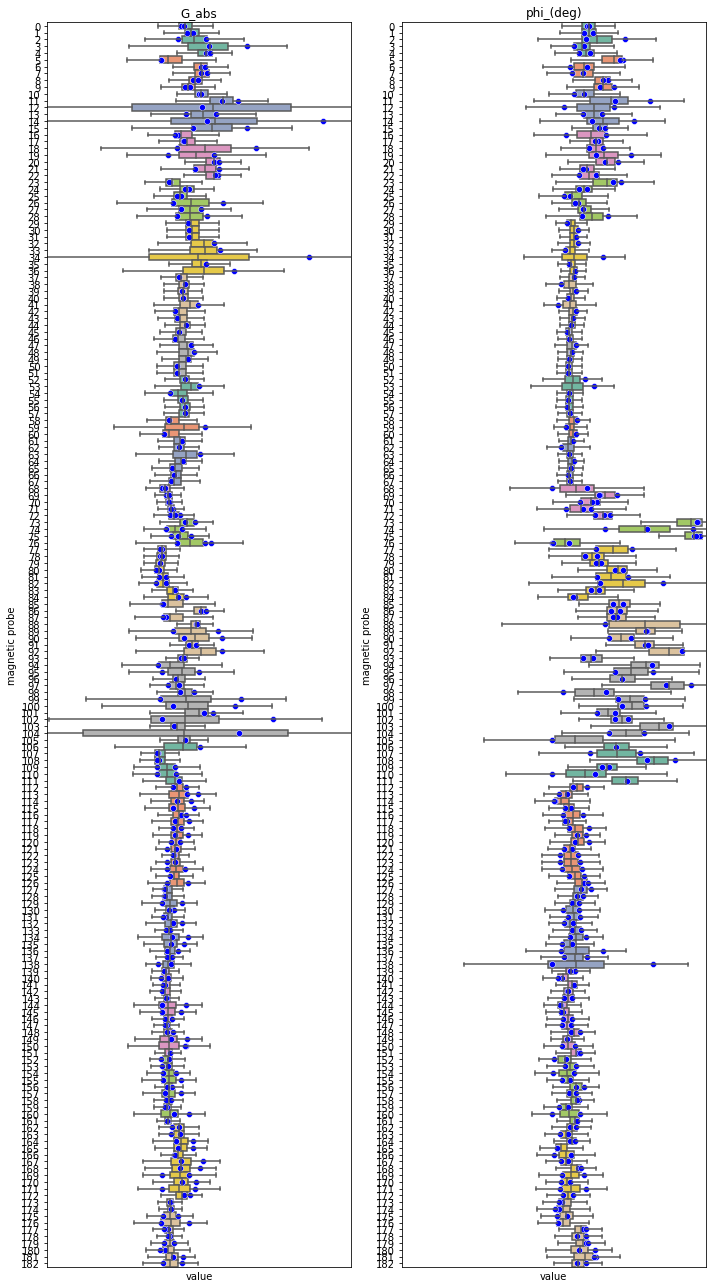

In [20]:
vis_raw('holder')

### materials colored

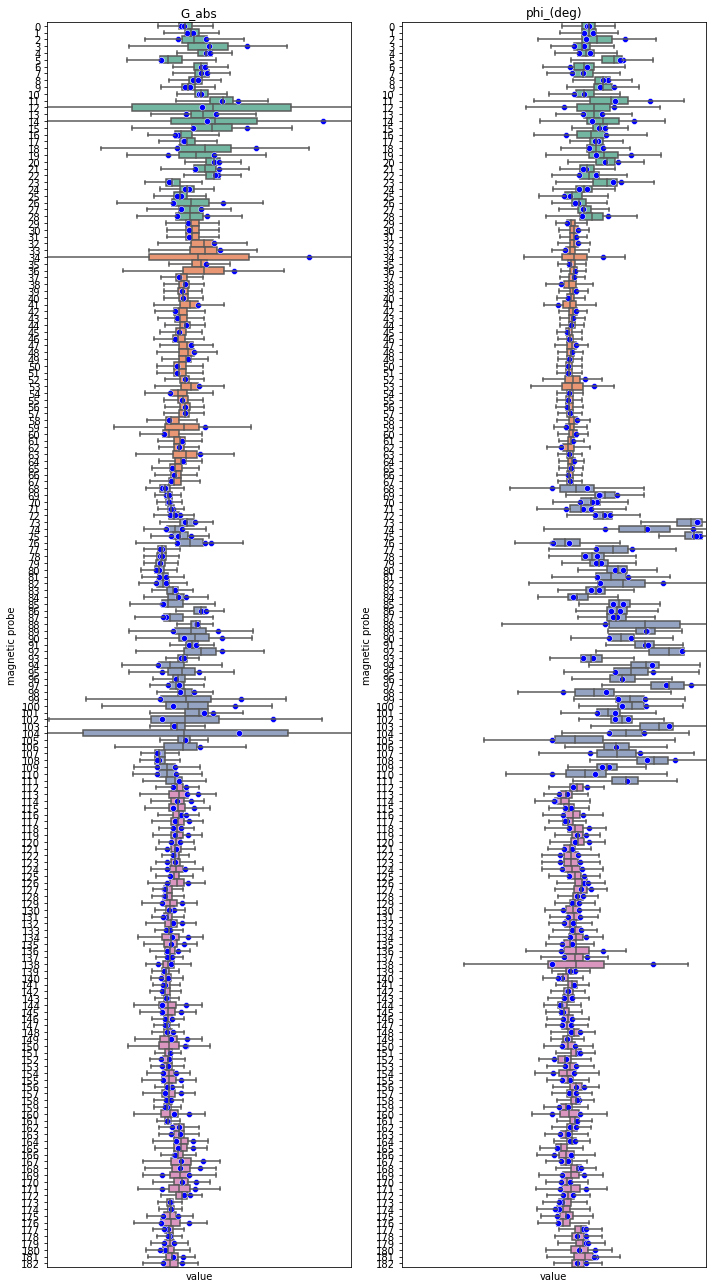

In [21]:
vis_raw('material')

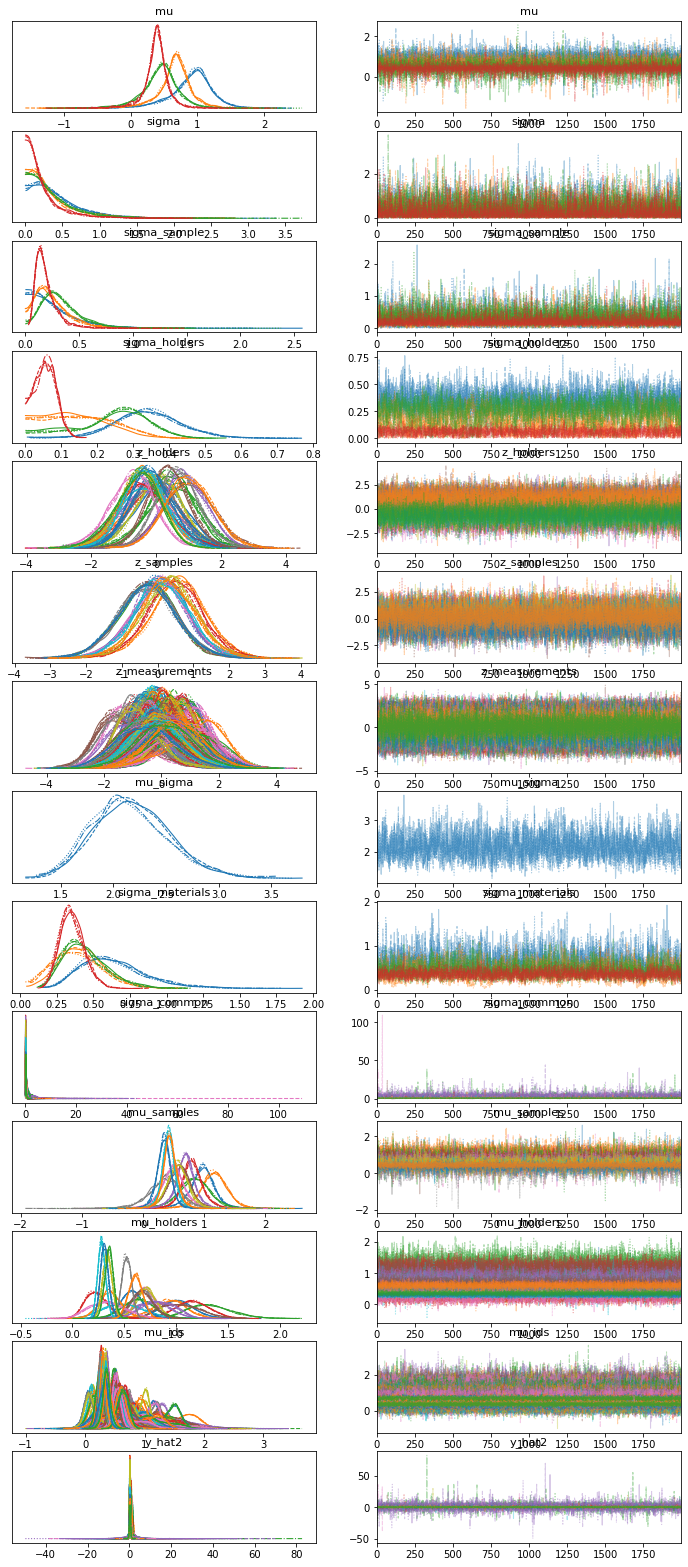

In [22]:
_ = az.plot_trace(az_out['G_abs'])

(-5.0, 5.0)

/home/ossi/anaconda3/envs/stan/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


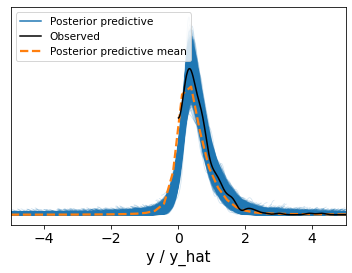

In [23]:
az.plot_ppc(az_out['G_abs'],data_pairs={"y": "y_hat"})
plt.xlim([-5,5])

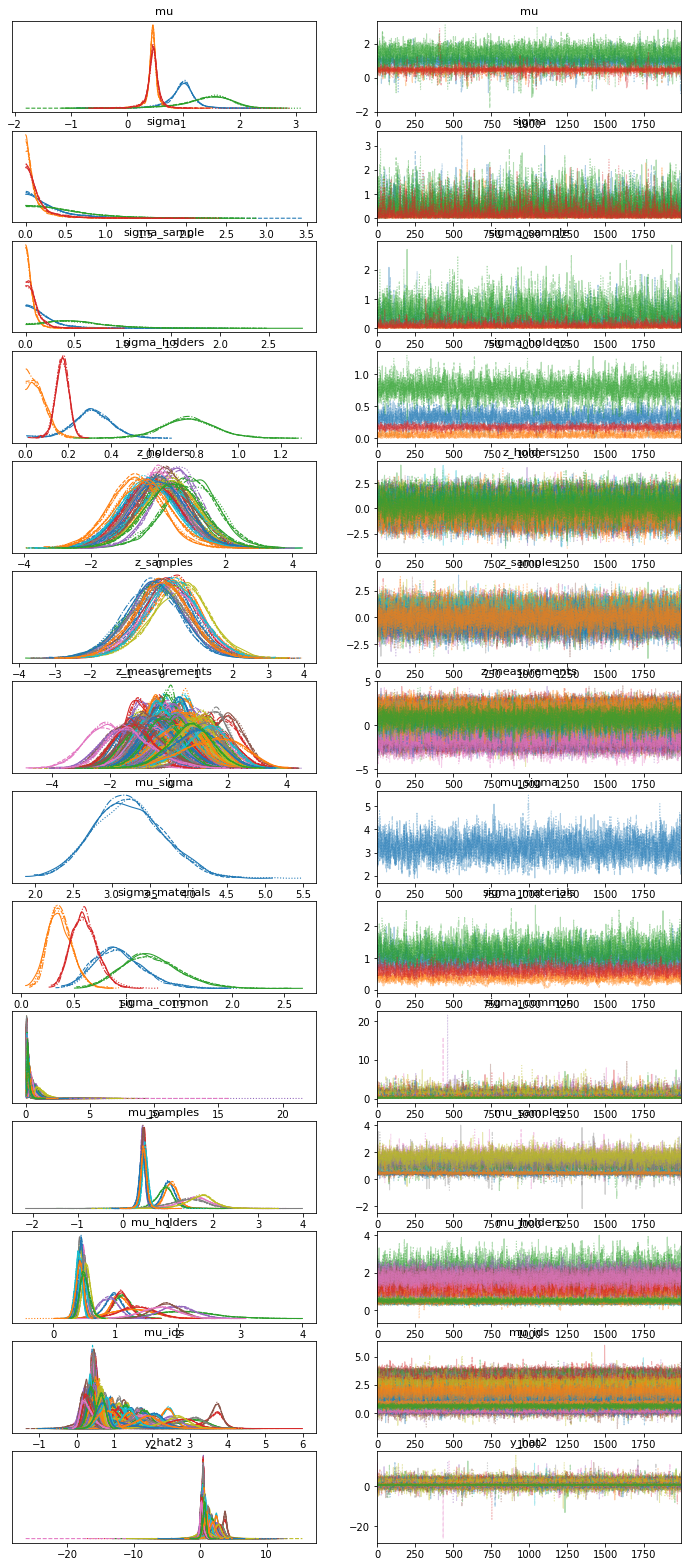

In [24]:
_ = az.plot_trace(az_out['phi_(deg)'])

(-5.0, 5.0)

/home/ossi/anaconda3/envs/stan/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


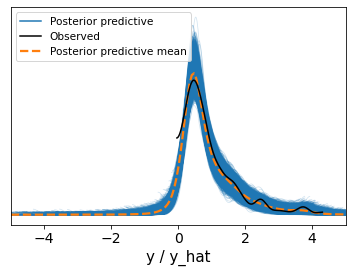

In [25]:
az.plot_ppc(az_out['phi_(deg)'],data_pairs={"y": "y_hat"})
plt.xlim([-5,5])

### Draw the sample-to-sample variation plot

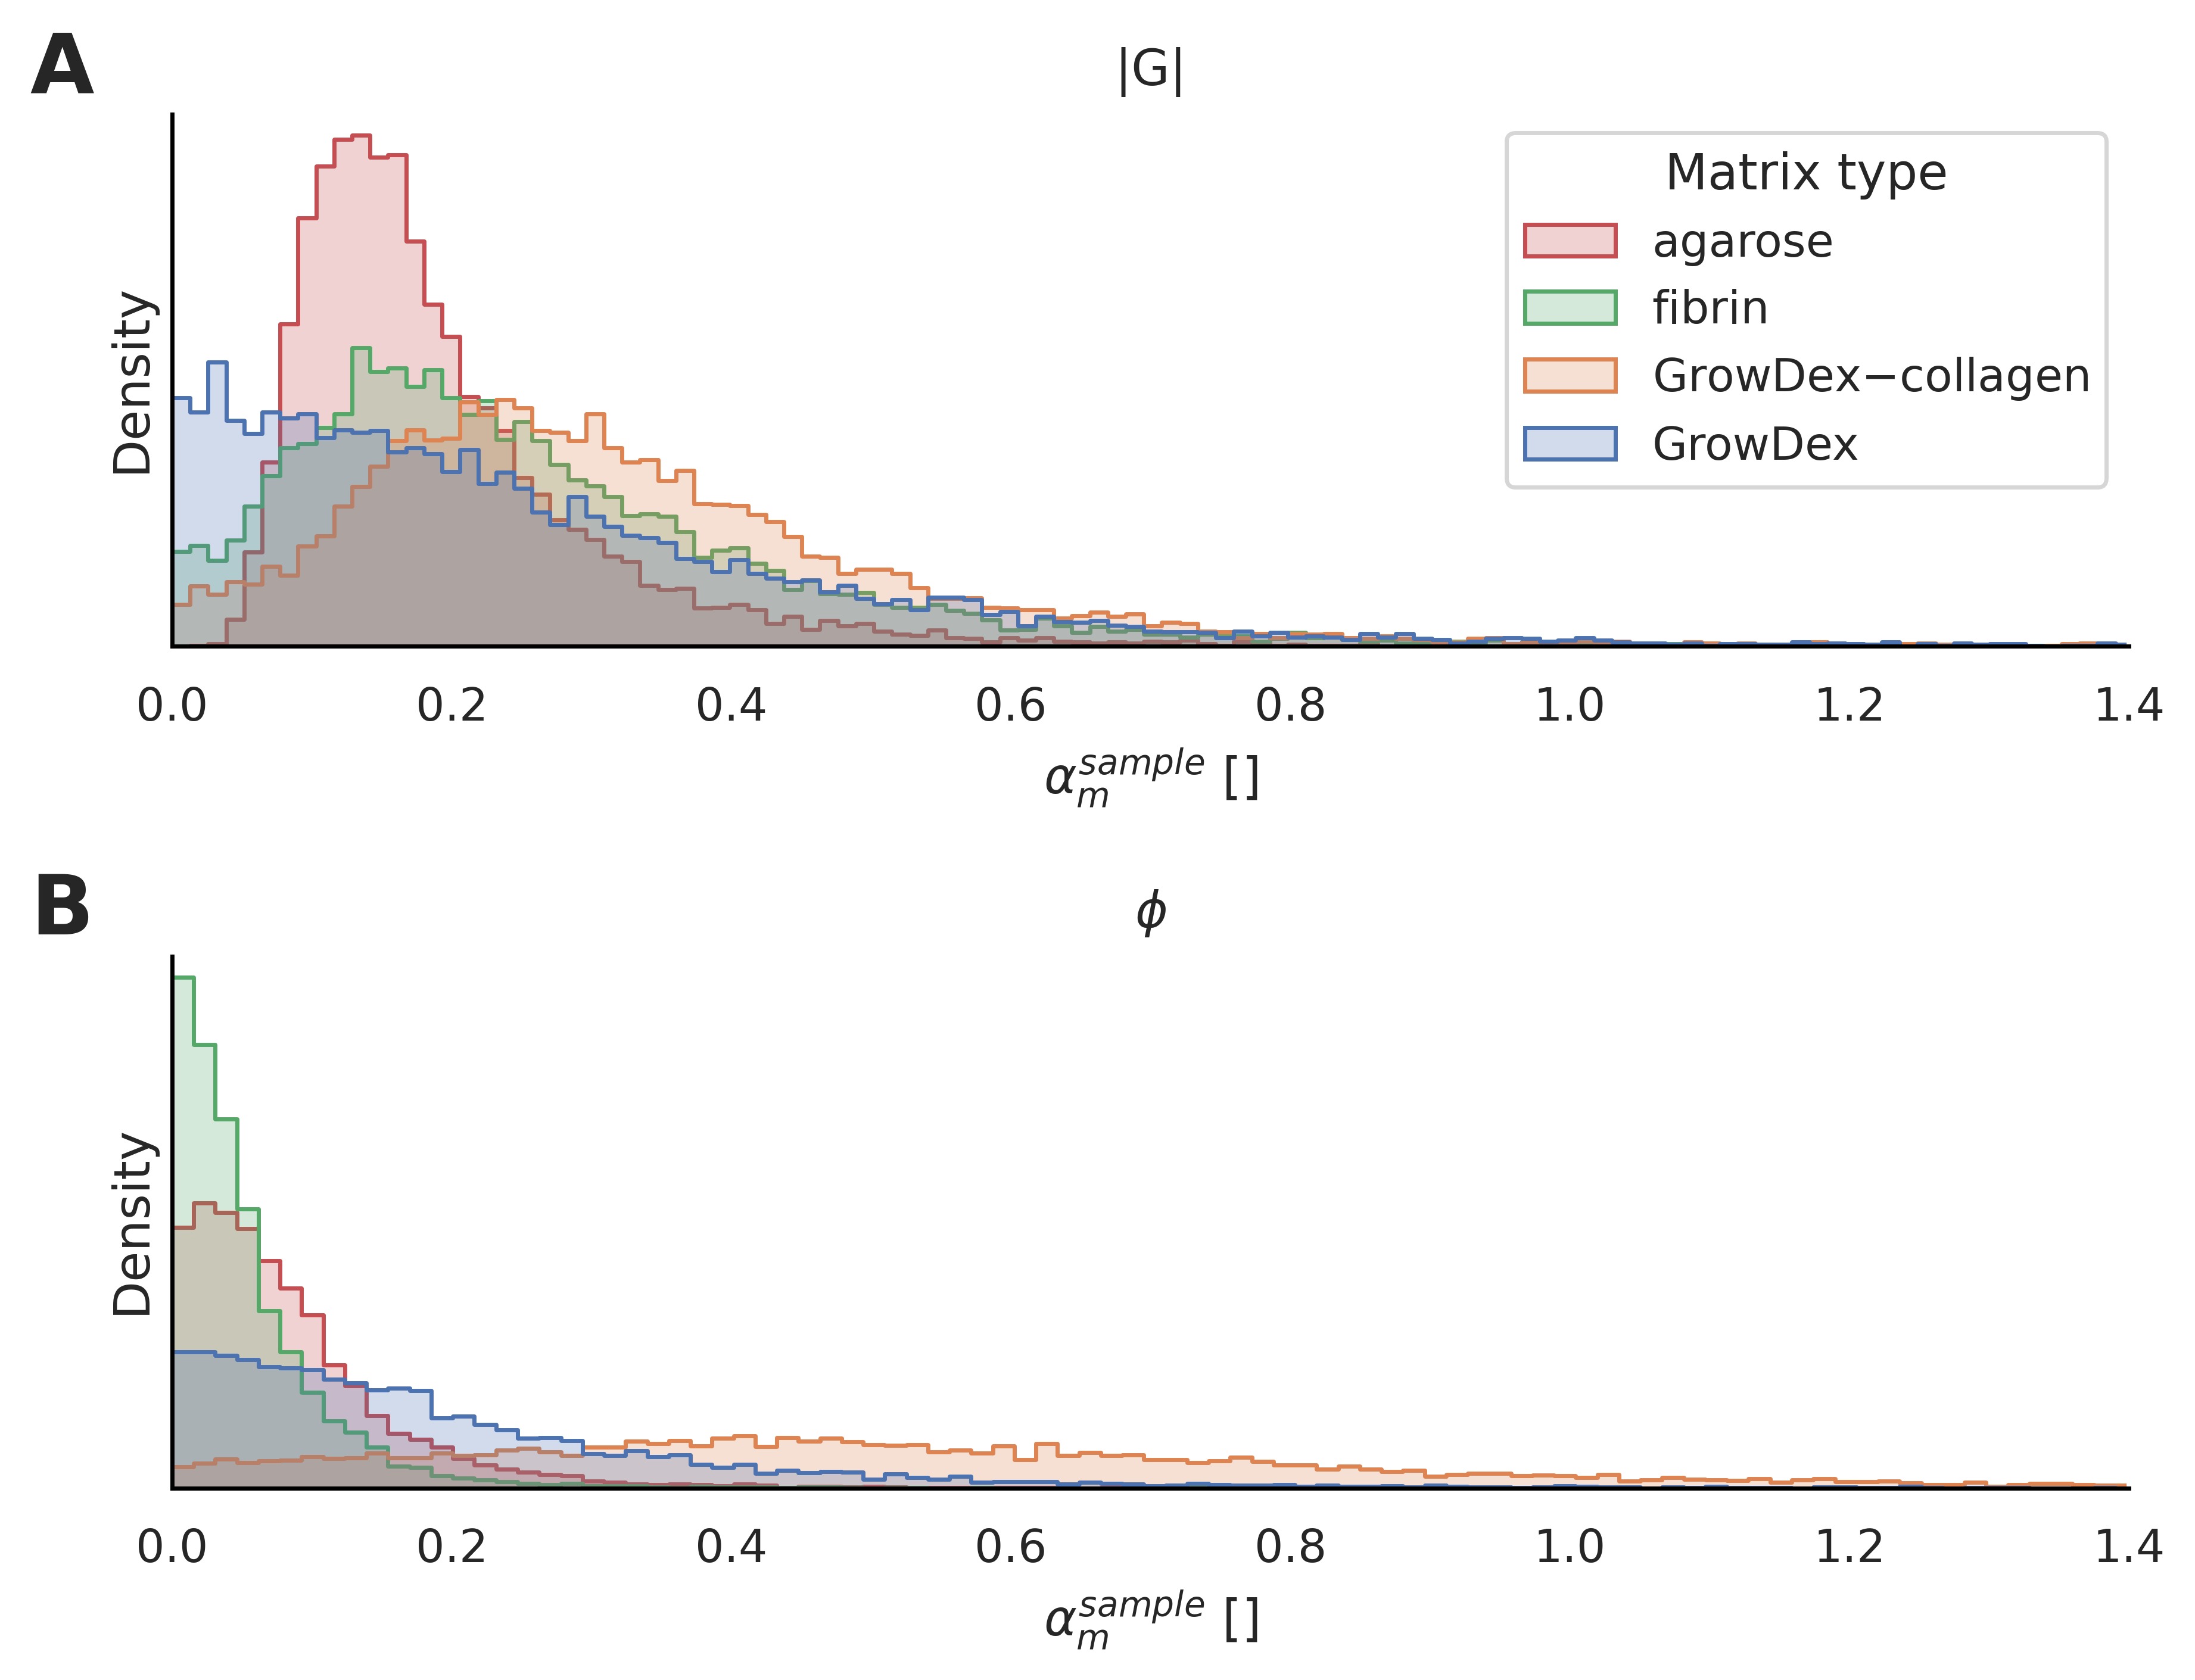

In [9]:
sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0),"legend.facecolor":(0, 0, 0, 1),'axes.grid':True})

def plot_sample_variation(name,ax):
    sample_variations = hh[name].filter(regex='^sigma_sample')
    sample_variations.columns = ['GrowDex','Fibrin','GrowDex-Collagen','Agarose']
    # same color,material pairs as in the heterogeneity plot
    sample_variations = sample_variations.iloc[:,[0,2,1,3]]
    sample_variations_melt = sample_variations.melt()
    sns.histplot(data=sample_variations_melt,x='value',hue='variable',ax=ax,
                 element="step",stat='density',discrete=False)

    ax.set_xlim([0,1.4])
    ax.set_yticks([])
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.set_xlabel(r'$\alpha^{sample}_m$ []')



fig,ax = plt.subplots(2,1,figsize=(7.5,8.75/1.5),dpi=500)
sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0),"legend.facecolor":(0, 0, 0, 1),'axes.grid':True})
plot_sample_variation('G_abs',ax[0])
plot_sample_variation('phi_(deg)',ax[1])

labs = ['agarose','fibrin','GrowDex$-$collagen','GrowDex']
legend = ax[0].legend(title='Matrix type', loc='upper right',
             labels=labs,
             facecolor='white')

#ax[1].set_ylabel('')
ax[1].get_legend().remove()

ax[0].set_title('|G|')
ax[1].set_title(r'$\phi$')

f_s = 20
ax[0].text(-0.04, 1.15, 'A', transform=ax[0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
ax[1].text(-0.04, 1.15, 'B', transform=ax[1].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')


fig.tight_layout()
fig.savefig(os.path.join('/mnt/c/Users/arasalo1/Pictures/paper1','sample_to_sample.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})
fig.savefig(os.path.join('/mnt/c/Users/arasalo1/Pictures/paper1','sample_to_sample.png'),dpi=500, format="png")

### Draw the heterogeneity plot from the paper

In [10]:
# create the same plot as in the paper
def plot_results(hh,save=False):
    mat_names = ['Absolute Complex Shear Modulus','Phase Angle']
    mats = ['GrowDex','Fibrin','GrowDex-Collagen','Agarose']
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0),"legend.facecolor":(0, 0, 0, 1),'axes.grid':True})
    fig = plt.figure(figsize=(7.5,8.75),constrained_layout=True,dpi=500)
    subfigs = fig.subfigures(2, 1, wspace=0.,hspace=0., height_ratios=[1, 1.])
    ax = subfigs[0].subplots(2, 1)
    # heterogeneity plots

    #sns.set_palette(sns.color_palette("colorblind", 4))
    order = [0,2,1,3]
    all_sigmas = []
    for ii,prop in enumerate(list(hh.keys())):
        hh1= hh[prop].filter(regex='^sigma_holders').values
        for i in order:
            all_sigmas.append(pd.DataFrame({'sigma':hh1[:,i],'material':mats[i],'cond':prop}))
    all_sigmas = pd.concat(all_sigmas)
    all_sigmas.index = np.arange(all_sigmas.shape[0])
    
    
    
    ax[0] = sns.histplot(data=all_sigmas[all_sigmas['cond']=='G_abs'],x='sigma',
                 hue='material',bins=80,ax=ax[0],alpha=0.6,stat='density',discrete=False,legend=True)
    ax[1] = sns.histplot(data=all_sigmas[all_sigmas['cond']=='phi_(deg)'],x='sigma',discrete=False,
                 hue='material',bins=80,ax=ax[1],alpha=0.6,stat='density',legend=False)

    ax[0].set_xlabel('',fontsize=12)

    ax[0].set_title(r'$|G|$')
    ax[1].set_title(r'$\phi$')
    ax[0].set_xlabel(r'$\alpha^{holder}_m$ []',fontsize=12)
    ax[1].set_xlabel(r'$\alpha^{holder}_m$ []',fontsize=12)
    ax[0].tick_params(labelsize=9)
    ax[1].tick_params(labelsize=9)
    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[0].yaxis.major.formatter._useMathText = True
    ax[1].yaxis.major.formatter._useMathText = True
    
    labs = ['agarose','fibrin','GrowDex$-$collagen','GrowDex']

    legend = ax[0].legend(title='Matrix type', loc='upper right',
                 labels=labs,
                 facecolor='white')

    ax[0].set_xlim([0,1.0])
    ax[1].set_xlim([0,1.0])
    ax[0].set_yticks([])
    ax[1].set_yticks([])
    ax[0].set_ylabel('Density')
    ax[1].set_ylabel('Density')
    for i in ax:
        i.spines['bottom'].set_linewidth(1)
        i.spines['bottom'].set_color('black')
        i.spines['left'].set_linewidth(1)
        i.spines['left'].set_color('black')


    # error plots
    ax2 = subfigs[1].subplots(2, 2)
    all_sigmas = []
    all_sigmas2 = []
    for ii,prop in enumerate(list(hh.keys())):
        hh1 = hh[prop].filter(regex='^mu_sigma')
        hh2 = hh[prop].filter(regex='^sigma_materials')
        all_sigmas.append(pd.DataFrame({'sigma':hh1.iloc[:,0].values,'material':None,'cond':prop}))
        for i in range(hh2.shape[-1]):
            all_sigmas2.append(pd.DataFrame({'sigma':hh2.values[:,i],'material':mats[i],'cond':prop}))

    all_sigmas = pd.concat(all_sigmas)
    all_sigmas.index = np.arange(all_sigmas.shape[0])
    all_sigmas2 = pd.concat(all_sigmas2)
    all_sigmas2.index = np.arange(all_sigmas2.shape[0])

    sns.histplot(data=all_sigmas[all_sigmas['cond']=='G_abs'],alpha=0.5,color='black',x='sigma',bins=100,ax=ax2[0,0],stat='density')
    sns.histplot(data=all_sigmas[all_sigmas['cond']=='phi_(deg)'],alpha=0.5,color='black',x='sigma',bins=100,ax=ax2[0,1],stat='density')

    sns.histplot(data=all_sigmas2[all_sigmas2['cond']=='G_abs'],x='sigma',hue='material',bins=100,ax=ax2[1,0],stat='density')
    sns.histplot(data=all_sigmas2[all_sigmas2['cond']=='phi_(deg)'],x='sigma',hue='material',bins=100,ax=ax2[1,1],stat='density')
    ax2[0,0].set_xlabel(r'$\sigma^{\mu}$ []')
    ax2[0,1].set_xlabel(r'$\sigma^{\mu}$ []')

    ax2[0,0].set_title('$|G|$', rotation=0)
    ax2[0,1].set_title(r'$\phi$',rotation=0)
    ax2[1,0].set_title('$|G|$', rotation=0)
    ax2[1,1].set_title(r'$\phi$',rotation=0)
    ax2[1,0].set_xlabel(r'$\sigma^{\sigma}_m$ []')
    ax2[1,1].set_xlabel(r'$\sigma^{\sigma}_m$ []')

    ax2[0,0].legend().remove()
    ax2[1,0].legend().remove()
    ax2[0,1].legend().remove()
    ax2[1,1].legend().remove()

    ax2[0,0].set_yticks([])
    ax2[1,0].set_yticks([])
    ax2[0,1].set_yticks([])
    ax2[1,1].set_yticks([])
    
    ax2[0,0].set_xlim([0.,5.0])
    ax2[0,1].set_xlim([0.,5.0])
    
    ax2[1,0].set_xlim([0.,2.2])
    ax2[1,1].set_xlim([0.,2.2])

    for i in range(2):
        for j in range(2):
            ax2[i,j].spines['bottom'].set_linewidth(1)
            ax2[i,j].spines['bottom'].set_color('black')
            ax2[i,j].spines['left'].set_linewidth(1)
            ax2[i,j].spines['left'].set_color('black')


    # labels
    f_s = 20
    ax[0].text(-0.04, 1.15, 'A', transform=ax[0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    ax[1].text(-0.04, 1.15, 'B', transform=ax[1].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')

    ax2[0,0].text(-0.1, 1.15, 'C', transform=ax2[0,0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    ax2[1,0].text(-0.1, 1.15, 'E', transform=ax2[1,0].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    ax2[0,1].text(-0.1, 1.15, 'D', transform=ax2[0,1].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    ax2[1,1].text(-0.1, 1.15, 'F', transform=ax2[1,1].transAxes,fontsize=f_s, fontweight='bold', va='top', ha='right')
    if save:
        fig.savefig(os.path.join(full_path,'model_results.tif'),dpi=500, format="tif", pil_kwargs={"compression": "tiff_lzw"})

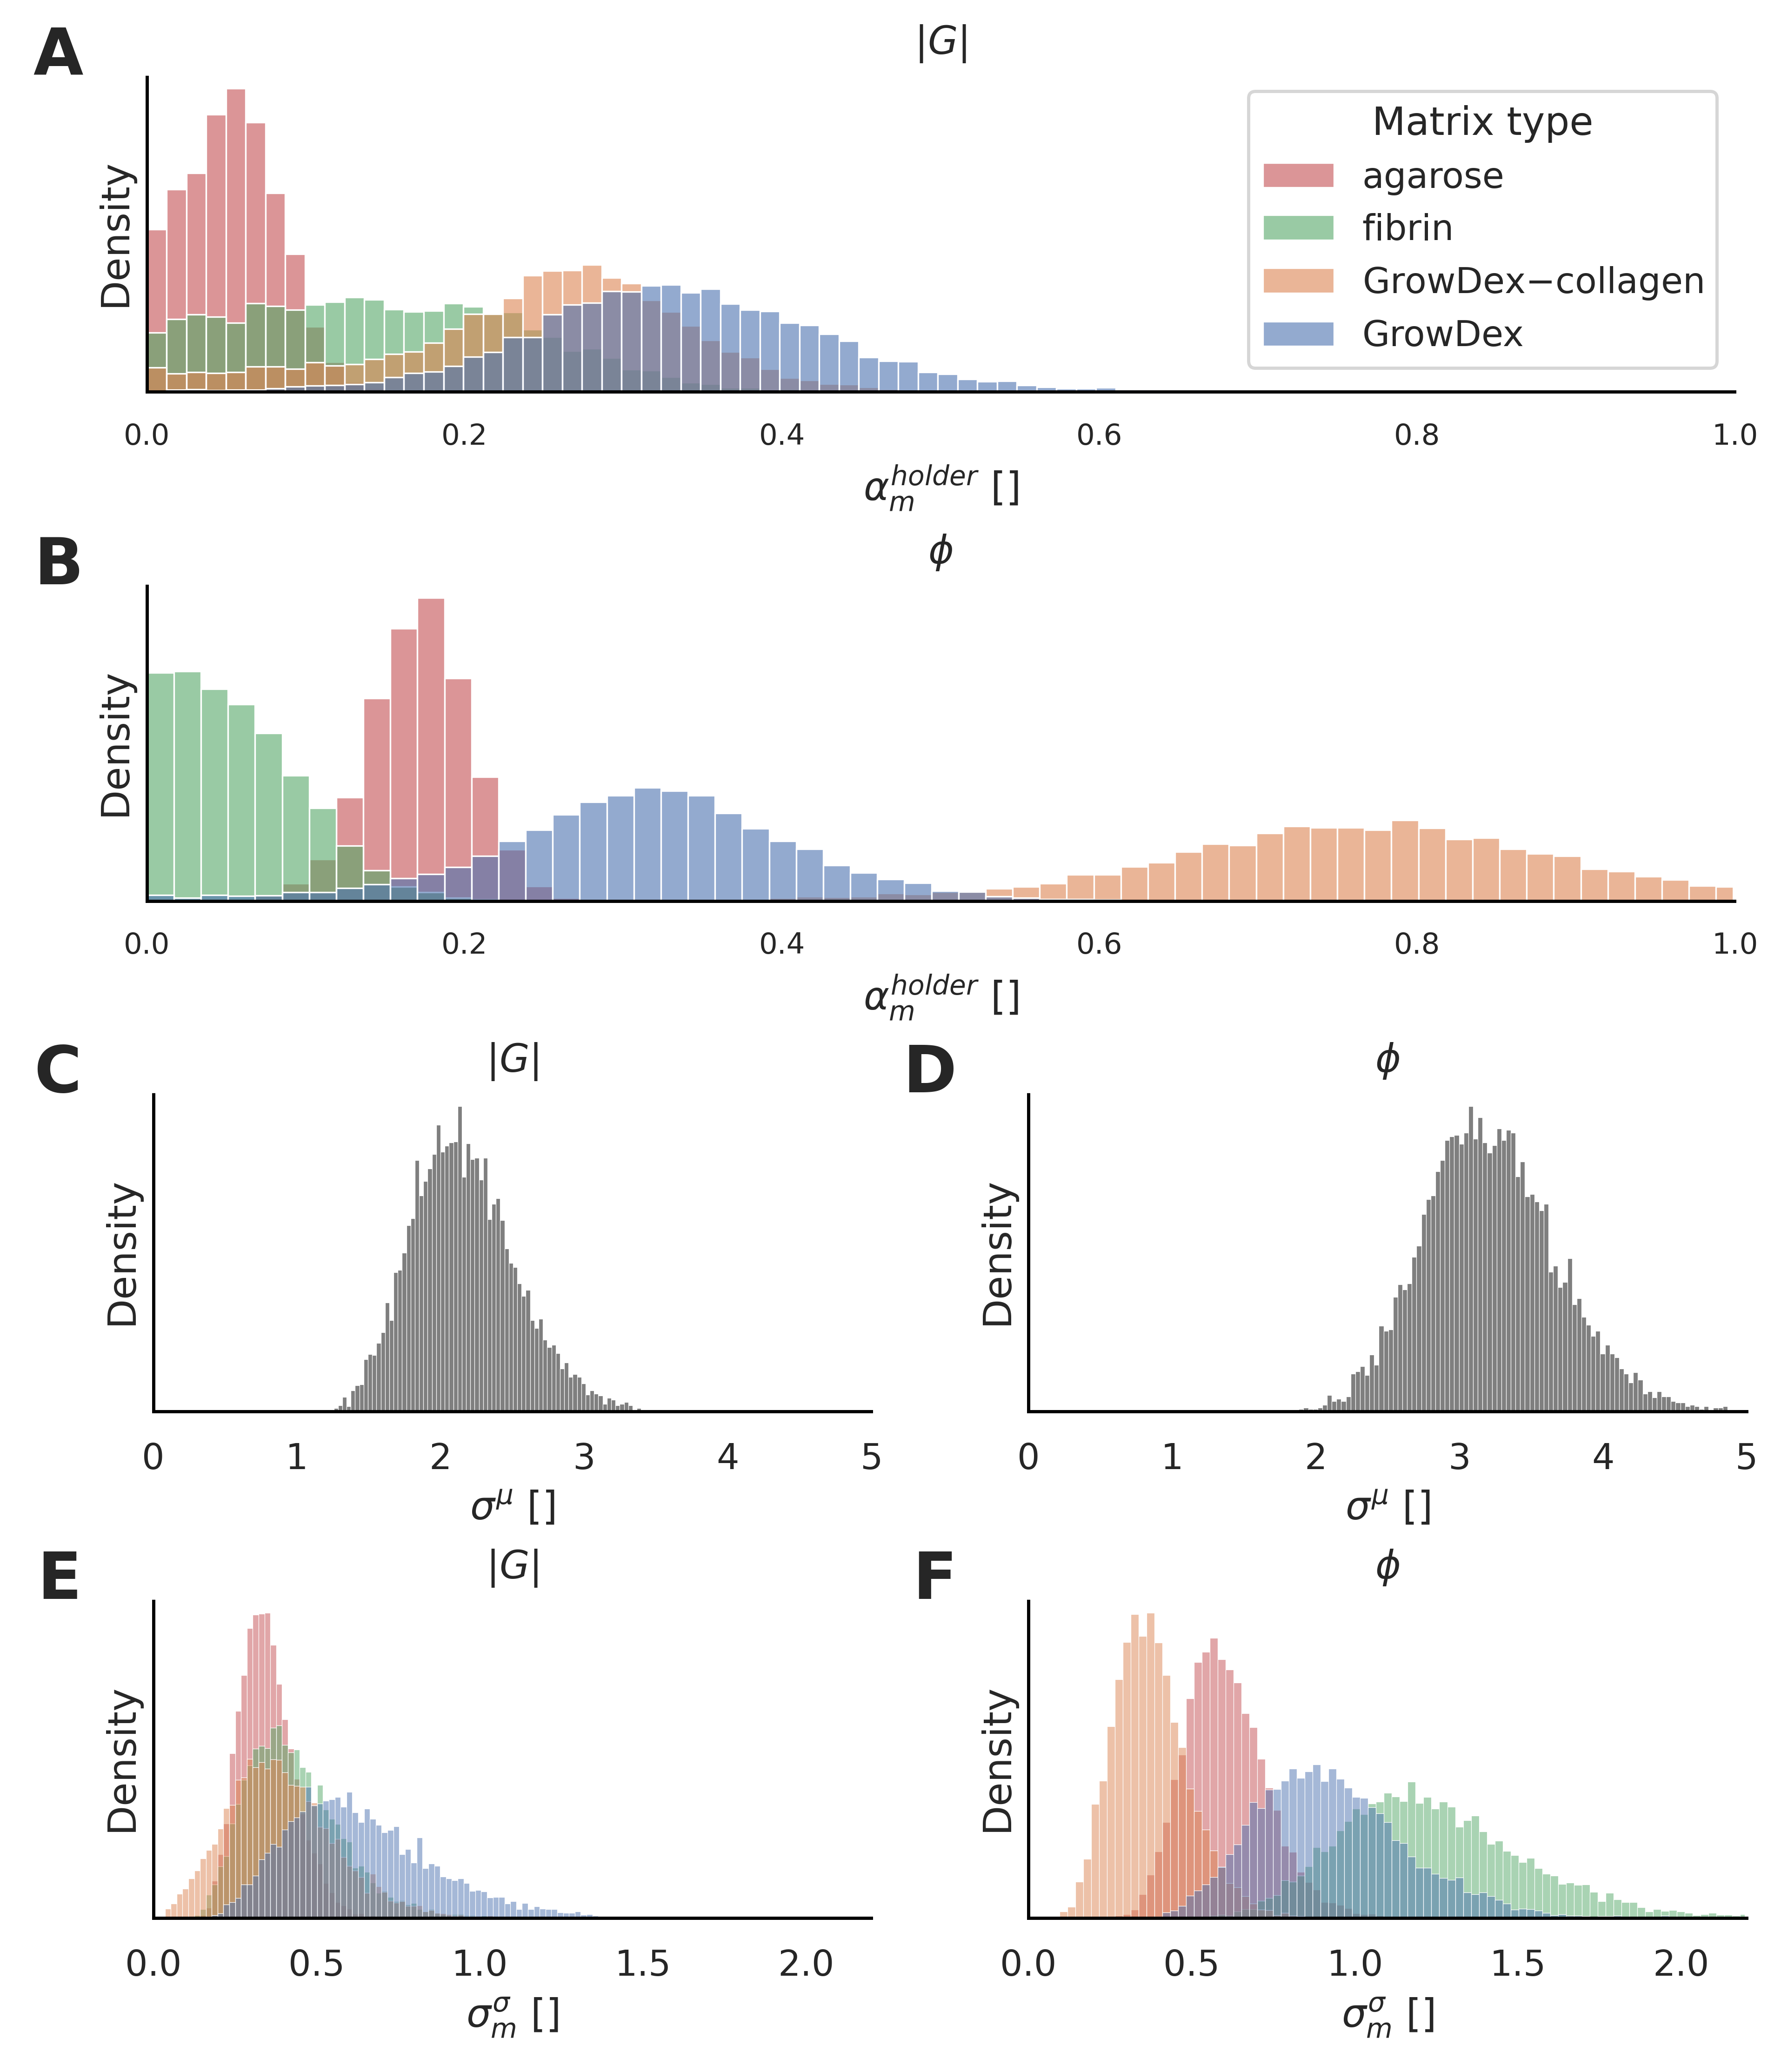

In [11]:
plot_results(hh,save=False)

## Compute the probabilites of the order 

In [145]:
all_sigmas = []
mats = ['GrowDex','Fibrin','GrowDex-Collagen','Agarose']
for ii,prop in enumerate(list(hh.keys())):
    hh1= hh[prop].filter(regex='^sigma_holders').values
    for i in range(hh1.shape[-1]):
        all_sigmas.append(pd.DataFrame({'sigma':hh1[:,i],'material':mats[i],'cond':prop}))
all_sigmas = pd.concat(all_sigmas)

def fil(m,c):
    return all_sigmas[(all_sigmas['material']==m) & (all_sigmas['cond']==c)]['sigma'].values
def comp(name1,name2,c):
    a = fil(name1,c)
    b = fil(name2,c)
    r = np.sum((a-b)>0)/a.shape[0]
    print('P( {} > {} ) = {:.4f}'.format(name1,name2,r),end='\n')
    return r
def comp_all(names,visco):
    probs = {}
    for i in names:
        probs[i] = {}
        for j in names:
            probs[i][j] = comp(i,j,visco)
    return probs

## small differences over runs expected

In [146]:
print('|G|')
probs_g = comp_all(mats,'G_abs')
print('phi')
probs_phi = comp_all(mats,'phi_(deg)')

|G|
P( GrowDex > GrowDex ) = 0.0000
P( GrowDex > Fibrin ) = 0.9190
P( GrowDex > GrowDex-Collagen ) = 0.7171
P( GrowDex > Agarose ) = 0.9885
P( Fibrin > GrowDex ) = 0.0810
P( Fibrin > Fibrin ) = 0.0000
P( Fibrin > GrowDex-Collagen ) = 0.2018
P( Fibrin > Agarose ) = 0.7980
P( GrowDex-Collagen > GrowDex ) = 0.2829
P( GrowDex-Collagen > Fibrin ) = 0.7983
P( GrowDex-Collagen > GrowDex-Collagen ) = 0.0000
P( GrowDex-Collagen > Agarose ) = 0.9580
P( Agarose > GrowDex ) = 0.0115
P( Agarose > Fibrin ) = 0.2020
P( Agarose > GrowDex-Collagen ) = 0.0420
P( Agarose > Agarose ) = 0.0000
phi
P( GrowDex > GrowDex ) = 0.0000
P( GrowDex > Fibrin ) = 0.9892
P( GrowDex > GrowDex-Collagen ) = 0.0047
P( GrowDex > Agarose ) = 0.9195
P( Fibrin > GrowDex ) = 0.0107
P( Fibrin > Fibrin ) = 0.0000
P( Fibrin > GrowDex-Collagen ) = 0.0001
P( Fibrin > Agarose ) = 0.0297
P( GrowDex-Collagen > GrowDex ) = 0.9952
P( GrowDex-Collagen > Fibrin ) = 0.9999
P( GrowDex-Collagen > GrowDex-Collagen ) = 0.0000
P( GrowDex-Collag

## G order prob

In [119]:
probs_g['GrowDex']['Fibrin']*probs_g['GrowDex']['GrowDex-Collagen']*\
probs_g['GrowDex']['Agarose']*\
probs_g['GrowDex-Collagen']['Agarose']*probs_g['GrowDex-Collagen']['Fibrin']*\
probs_g['Fibrin']['Agarose']

0.41312242069529687

## $\phi$ order prob

In [118]:
probs_phi['GrowDex-Collagen']['GrowDex']*probs_phi['GrowDex-Collagen']['Fibrin']*\
probs_phi['GrowDex-Collagen']['Agarose']*probs_phi['GrowDex']['Agarose']*\
probs_phi['GrowDex']['Fibrin']*probs_phi['Agarose']['Fibrin']

0.8733565010381542

# ELPD

In [120]:
import warnings
import logging
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)

In [121]:
def stat(d):
    means = []
    se = []
    for elpds in d:
        means.append(np.sum(elpds))
        se.append(np.sqrt(len(elpds))*np.std(elpds))
    return means,se

In [122]:
def elpd(model_name):
    """Same as pred,expect run the model n times leaving one probe/particle out at a time"""
    all_elpds = []
    out = {}
    for g_a in tqdm(['G_abs','phi_(deg)']):
        samples = []
        out[g_a] = {}
        for ss in ['GrowDex','Fibrin','GrowDex-Collagen']:
            data = pd.read_csv(os.path.join(full_path,'heterogeneity','data','hetero_data.csv'))
            data_type = ss
            data = data[data['type']==data_type]

            sample_num = []
            prev = None
            idx = 1
            for i in data['day']:
                if prev is None:
                    prev = i
                if prev != i:
                    idx += 1
                    prev = i
                sample_num.append(idx)
            data['sample_num'] = sample_num
            if ss=='Fibrin':
                u_i = data['sample'].unique()
                iid = np.arange(1,u_i.shape[0]+1)
                s_out = data['sample'].copy()
                for ii,i in enumerate(u_i):
                    s_out[data['sample']==i] = iid[ii]
                data['sample_num'] = s_out

            #subset = data[data['sample']==10][['sample_num','holder','location','G_abs']]
            subset = data[['sample_num','holder','location','track_id',g_a]]
            #subset = data[['sample_num','holder','location','phi_(deg)']]
            subset['sample_num'] = subset['sample_num'].astype(int)
            sample_ids = []
            location_ids = []
            holder_ids = []
            track_ids = []
            n_loc = 0
            n_hold = 0
            n_samp = 0
            for i in subset['sample_num'].unique():
                sub_sample = subset[subset['sample_num']==i]
                sample_ids.extend([int(i)]*sub_sample['holder'].unique().shape[0])
                for jj,j in enumerate(sub_sample['holder'].unique()):
                    sub = sub_sample[sub_sample['holder']==j]
                    holder_ids.extend([int(jj+1)+n_samp]*sub['location'].unique().shape[0])
                    for kk,k in enumerate(sub['location'].unique()):
                        sub2 = sub[sub['location']==k]
                        location_ids.extend([int(kk+1)+n_hold]*sub2['track_id'].unique().shape[0])
                        for zz,z in enumerate(sub2['track_id'].unique()):
                            sub3 = sub2[sub2['track_id']==z]
                            track_ids.extend([int(zz+1)+n_loc]*sub3.shape[0])
                        n_loc += int(sub2['track_id'].unique().shape[0])
                    n_hold += int(sub['location'].unique().shape[0])
                n_samp += int(sub_sample['holder'].unique().shape[0])
            #print(sample_ids)
            #print(holder_ids)
            #print(location_ids)  
            #print(track_ids)
            #y_raw = subset['phi_(deg)'].values
            y_raw = subset[g_a].values
            y = y_raw-np.mean(y_raw)
            if g_a == 'G_abs':
                y = y_raw/G_std
            else:
                y = y_raw/phi_std
            #y = (y_raw-np.mean(y_raw))/(np.std(y_raw))
            sample = {'N':subset.shape[0],
                      'N_samples':int(np.max(sample_ids)),
                      'N_holders': int(np.max(holder_ids)),
                      'N_locations': int(np.max(location_ids)),
                      'N_ids':int(np.max(track_ids)),
                      'sample_ids':sample_ids,
                      'holder_ids':holder_ids,
                      'location_ids':location_ids,
                      'track_ids':track_ids,
                      'train_ids':(np.arange(len(track_ids))+1).tolist(),
                      'N_train': subset.shape[0],
                      'y':y.tolist()}

            samples.append(sample.copy())
        #print(samples)
        combined = samples[0]
        combined['material_ids'] = np.ones(combined['N_samples'],dtype=int).tolist()
        s_max = combined['N_samples']
        h_max = combined['N_holders']
        l_max = combined['N_locations']
        t_max = combined['N_ids']
        m_max = 1
        for s in samples[1:]:
            #print(s['N'])
            combined['N'] += s['N']
            combined['N_samples'] += s['N_samples']
            combined['N_holders'] += s['N_holders']
            combined['N_locations'] += s['N_locations']
            combined['N_ids'] += s['N_ids']
            combined['sample_ids'].extend((np.array(s['sample_ids'])+s_max).tolist())
            combined['holder_ids'].extend((np.array(s['holder_ids'])+h_max).tolist())
            combined['location_ids'].extend((np.array(s['location_ids'])+l_max).tolist())
            combined['track_ids'].extend((np.array(s['track_ids'])+t_max).tolist())
            combined['y'].extend(s['y'])
            combined['material_ids'].extend((np.ones(s['N_samples'],dtype=int)+m_max).tolist())

            s_max += s['N_samples']
            h_max += s['N_holders']
            l_max += s['N_locations']
            t_max += s['N_ids']
            m_max += 1

        
        combined['N_train'] = len(combined['train_ids'])

        combined['sample_ids'] = combined['sample_ids']
        combined['holder_ids'] = combined['holder_ids']
        combined['location_ids'] = combined['location_ids']
        combined['track_ids'] = combined['track_ids']
        combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
        combined['material_ids'] = np.array(combined['material_ids']).astype(int).tolist()
        combined['N_materials'] = len(samples)
        combined['train_ids'] = ((np.arange(combined['N'])+1).astype(int)).tolist()
        
        all_logs = []
        for i in tqdm(range(int(np.max(combined['track_ids']))),leave=False):
            # leave one probe out
            train_ids = np.arange(combined['N'])[np.array(combined['track_ids'])!=(i+1)]+1
            combined['train_ids'] = train_ids.astype(int).tolist()
            combined['N_train'] = len(train_ids)
            json_path = os.path.join(full_path,'heterogeneity','data','hier_data.json')
            with open(json_path,'w') as f:
                json.dump(combined,f)
            model = CmdStanModel(stan_file=os.path.join(full_path,'heterogeneity','models',f'{model_name}.stan'))
            fit = model.sample(data=json_path,
                               adapt_delta=0.9999999999999999,max_treedepth=20,show_progress=False)
            test_ids = np.arange(len(combined['track_ids']))[np.array(combined['track_ids'])==(i+1)]
            logs = fit.draws_pd().filter(regex=r'log_likelihood*').values[:,test_ids]
            all_logs.append(logs)
        loggs = np.hstack(all_logs)
        elpds = np.log(np.mean(np.exp(loggs),axis=0))
        all_elpds.append(elpds)
            #print(np.sum(elpds),np.sqrt(len(elpds))*np.std(elpds))
    return all_elpds

## Leave one probe out cross validation for ELPD

**These can take up to 4-5 hours**

In [123]:
partial = elpd('hier_material')
partial_stats = stat(partial)
partial_stats

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

([-162.65274478353723, -175.1606288820075],
 [16.67823907968412, 15.5627091488588])

In [125]:
full = elpd('hier_material_full')
full_stats = stat(full)
full_stats

In [ ]:
baseline = elpd('hier_material_baseline')
baseline_stats = stat(baseline)
baseline_stats

In [130]:
pool = elpd('hier_material_pool')
pool_stats = stat(pool)
pool_stats

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

([-159.4576343119591, -167.084268731869],
 [16.87542872678894, 14.210590328441334])

In [ ]:
baseline_noise = elpd('hier_material_baseline_noise')
baseline_noise_stats = stat(baseline_noise)
baseline_noise_stats

In [127]:
combined = pd.DataFrame({'elpd':np.concatenate([partial_stats[0],full_stats[0],
                                                pool_stats[0],baseline_stats[0],baseline_noise_stats[0]]),
                        'se':np.concatenate([partial_stats[1],full_stats[1],
                                             pool_stats[1],baseline_stats[1],baseline_noise_stats[1]]),
                        'model':np.concatenate([['model 1']*len(partial_stats[0]),
                                               ['model 2']*len(full_stats[0]),
                                               ['model 3']*len(pool_stats[0]),
                                               ['model 4']*len(baseline_stats[0]),
                                               ['model 5']*len(baseline_noise_stats[0])])})
combined['property'] = np.tile(['G','phi'],5)
combined

elpd         se    model property
0 -162.652745  16.678239  model 1        G
1 -175.160629  15.562709  model 1      phi
2 -153.505372  17.654360  model 2        G
3 -175.044546  15.681705  model 2      phi
4 -166.733471  16.629869  model 3        G
5 -166.883241  14.163177  model 3      phi
6 -169.539086  16.934008  model 4        G
7 -172.631493  15.575221  model 4      phi
8 -284.080725  58.914523  model 5        G
9 -171.043780  14.657215  model 5      phi

## Supplementary model comparison table

## Some randomness involved over runs
* ordering stays the same nonetheless

In [129]:
for idx,i in combined.groupby(['property']):
    l = i.sort_values('elpd',ascending=False).to_latex(index=False)
    l = l.replace('toprule','hline')
    l = l.replace('midrule','hline')
    l = l.replace('bottomrule','hline')
    l = l.replace('phi','$\phi$')
    print(l)

\begin{tabular}{rrll}
\hline
       elpd &        se &   model & property \\
\hline
-153.505372 & 17.654360 & model 2 &        G \\
-162.652745 & 16.678239 & model 1 &        G \\
-166.733471 & 16.629869 & model 3 &        G \\
-169.539086 & 16.934008 & model 4 &        G \\
-284.080725 & 58.914523 & model 5 &        G \\
\hline
\end{tabular}

\begin{tabular}{rrll}
\hline
       elpd &        se &   model & property \\
\hline
-166.883241 & 14.163177 & model 3 &      $\phi$ \\
-171.043780 & 14.657215 & model 5 &      $\phi$ \\
-172.631493 & 15.575221 & model 4 &      $\phi$ \\
-175.044546 & 15.681705 & model 2 &      $\phi$ \\
-175.160629 & 15.562709 & model 1 &      $\phi$ \\
\hline
\end{tabular}



## Results from other variants

In [22]:
hh,az_out = pred('hier_material_full',True)

/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:compiling stan program, exe file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_full
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheo

Processing csv files: /tmp/tmphxc_enku/hier_material_full-202207260852-1-sadn49kk.csv, /tmp/tmphxc_enku/hier_material_full-202207260852-2-tgx7zhk4.csv, /tmp/tmphxc_enku/hier_material_full-202207260852-3-w86_dyxs.csv, /tmp/tmphxc_enku/hier_material_full-202207260852-4-mgklbq2w.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_full
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO

Processing csv files: /tmp/tmphxc_enku/hier_material_full-202207260859-1-0fd9fkeh.csv, /tmp/tmphxc_enku/hier_material_full-202207260859-2-2nk0kmi7.csv, /tmp/tmphxc_enku/hier_material_full-202207260859-3-_t79n5fl.csv, /tmp/tmphxc_enku/hier_material_full-202207260859-4-fcrjbzn7.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 8000 (0.013%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


## Model 2

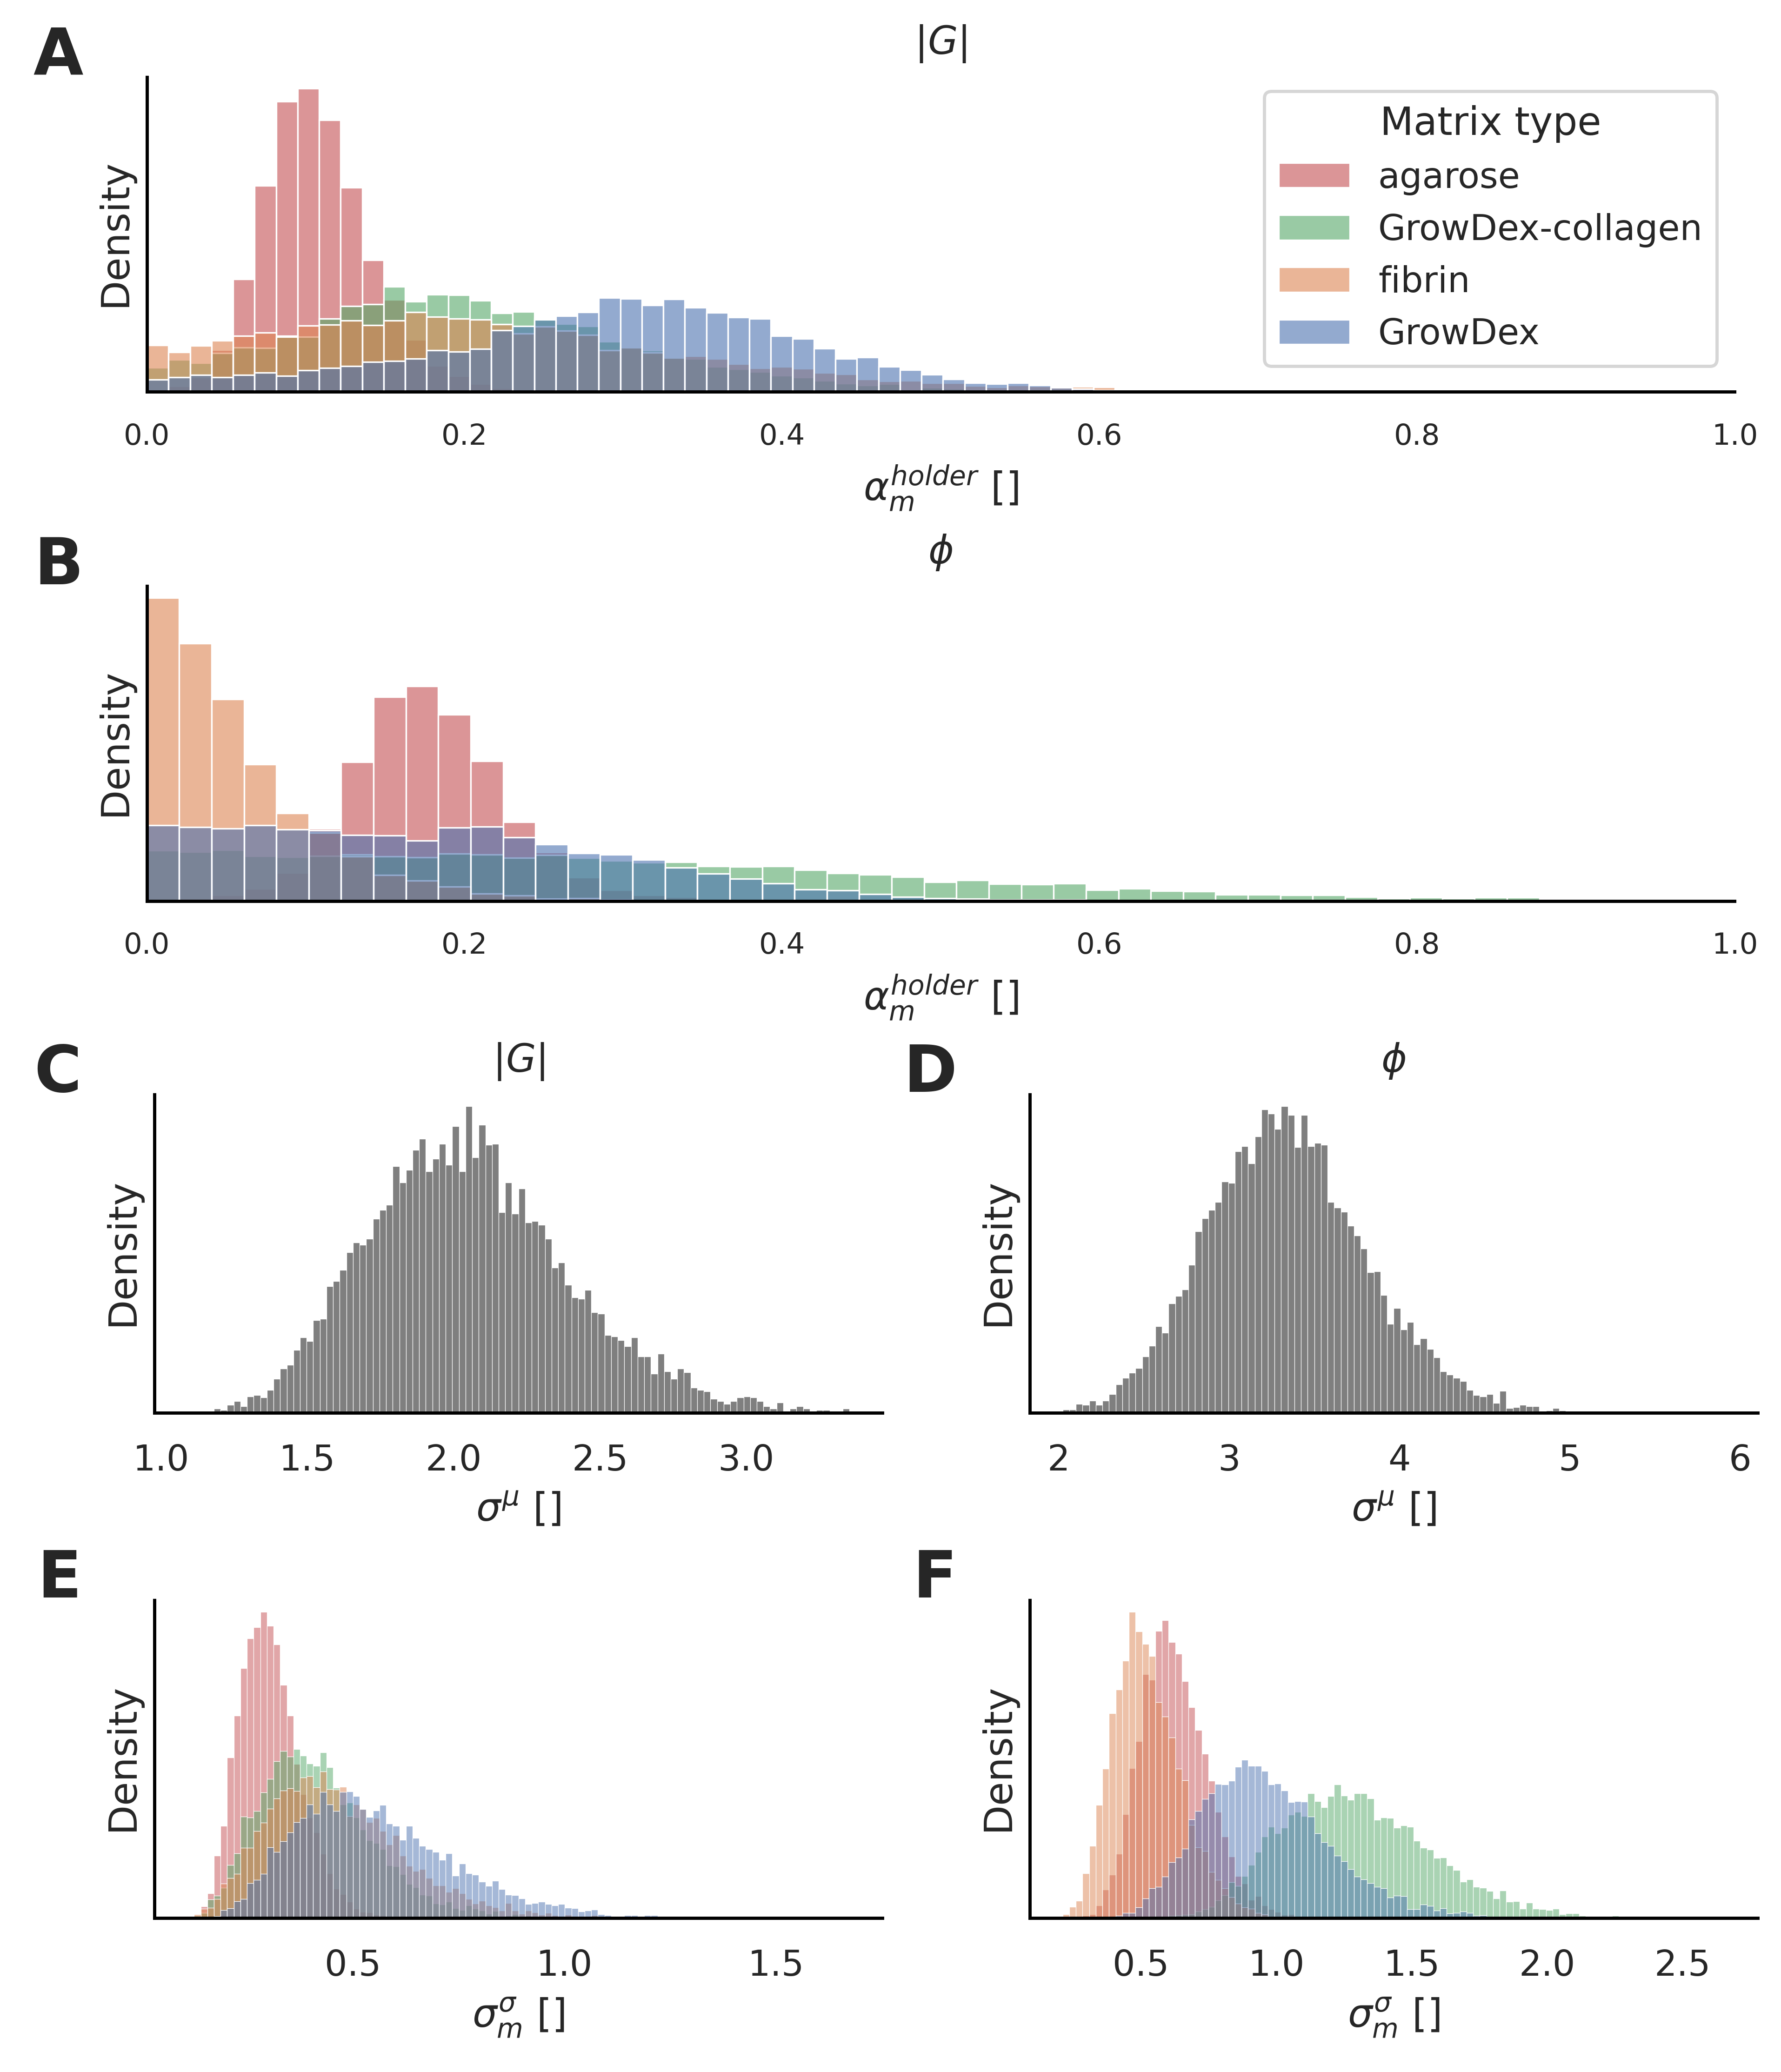

In [23]:
plot_results(hh,False)

## Model 3

In [25]:
hh2,az_out = pred('hier_material_pool',True)

/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_pool
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO

Processing csv files: /tmp/tmphxc_enku/hier_material_pool-202207260941-1-sbv98_ja.csv, /tmp/tmphxc_enku/hier_material_pool-202207260941-2-szurqzwb.csv, /tmp/tmphxc_enku/hier_material_pool-202207260941-3-w4g78quo.csv, /tmp/tmphxc_enku/hier_material_pool-202207260941-4-s9wxqlb2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_pool
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:Processing csv files: /tmp/tmphxc_enku/hier_material_pool-202207260942-1-4dvw3gx_.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-2-1mz55bde.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-3-a7uguahx.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-4-d0glbsq7.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values sa

Processing csv files: /tmp/tmphxc_enku/hier_material_pool-202207260942-1-4dvw3gx_.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-2-1mz55bde.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-3-a7uguahx.csv, /tmp/tmphxc_enku/hier_material_pool-202207260942-4-d0glbsq7.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

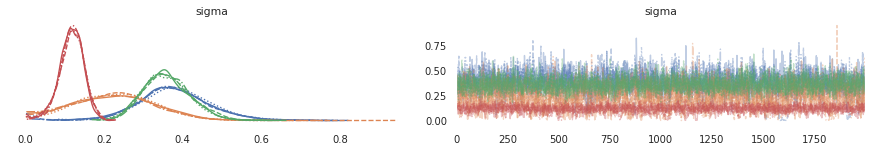

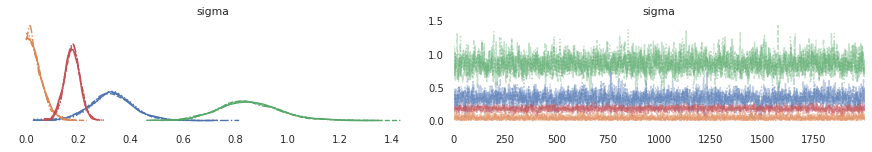

In [30]:
az.plot_trace(az_out['G_abs'],var_names=['sigma'])
az.plot_trace(az_out['phi_(deg)'],var_names=['sigma'])

## Model 4

* Heterogeneity is the width of the distribution
* Quite difficult to interpret

In [31]:
hh3,az_out = pred('hier_material_baseline',True)

/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:compiling stan program, exe file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_baseline
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/ossi/projects/micro

Processing csv files: /tmp/tmphxc_enku/hier_material_baseline-202207261006-1-w12ioblm.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-2-l10aybrd.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-3-votd5yjf.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-4-5u88iuw1.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_baseline
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3


Processing csv files: /tmp/tmphxc_enku/hier_material_baseline-202207261006-1-gqz_enkb.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-2-g462j100.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-3-c5jr0orh.csv, /tmp/tmphxc_enku/hier_material_baseline-202207261006-4-15ddt5n2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


array([[<AxesSubplot:title={'center':'mu_ids'}>,
        <AxesSubplot:title={'center':'mu_ids'}>]], dtype=object)

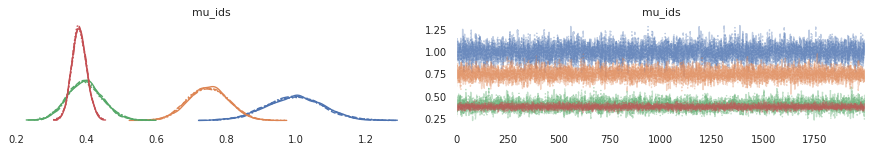

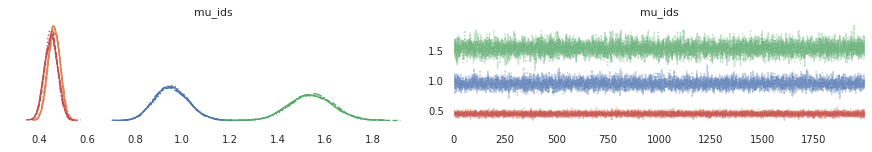

In [32]:
az.plot_trace(az_out['G_abs'],var_names=['mu_ids'])
az.plot_trace(az_out['phi_(deg)'],var_names=['mu_ids'])

In [38]:
np.std(hh3['G_abs'].filter(regex='mu_ids'),axis=0)

mu_ids[1]    0.081094
mu_ids[2]    0.057171
mu_ids[3]    0.050111
mu_ids[4]    0.021187
dtype: float64

## Model 5

* Looks more uncertain than the pooled noise example

In [33]:
hh4,az_out = pred('hier_material_baseline_noise',True)

/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:compiling stan program, exe file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_baseline_noise
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /home/ossi/projects

Processing csv files: /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-1-q4murn0e.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-2-xm35vq2i.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-3-k577ak9n.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-4-cibcft1r.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ossi/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/ossi/projects/microrheology/heterogeneity/models/hier_material_baseline_noise
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start ch

Processing csv files: /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-1-qdim6pju.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-2-a10mlzzd.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-3-kj250r7x.csv, /tmp/tmphxc_enku/hier_material_baseline_noise-202207261008-4-3pbkpwu2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


array([[<AxesSubplot:title={'center':'mu_ids'}>,
        <AxesSubplot:title={'center':'mu_ids'}>]], dtype=object)

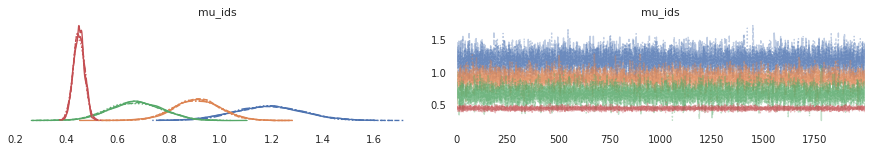

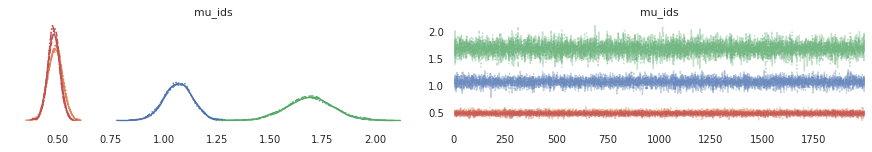

In [34]:
az.plot_trace(az_out['G_abs'],var_names=['mu_ids'])
az.plot_trace(az_out['phi_(deg)'],var_names=['mu_ids'])